In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import pickle
from time import time
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler

sns.set()
%matplotlib inline 

In [26]:
import sklearn
sklearn.__version__

'0.20.1'

### Carregando X e y

In [6]:
with open('../input/pickles/X_main.pkl', 'rb') as f:
    X = pickle.load(f)

with open('../input/pickles/y_main.pkl', 'rb') as f:
    y = pickle.load(f)

In [5]:
X.shape

(1901680, 47)

### Diminuindo o espaço de amostras.

1. O conjunto contém muitas amostras, o que torna a tarefa de treinar e testar os modelos muito díficil;
2. Avaliar um tamanho representativo.

## Feature Selection

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.2, random_state=42)

In [7]:
# Acurácia do modelo mais básico
sum(y_test) / y_test.shape[0]

0.34197393883303184

In [8]:
# Sem feature selection
basic_clf = GaussianNB()
basic_clf.fit(X_train, y_train)
y_pred = basic_clf.predict(X_test)
score = accuracy_score(y_test, y_pred)
print("Sem feature selection, accuracy = {}".format(score))
score = fbeta_score(y_test, y_pred, 2)
print("Sem feature selection, fbeta = {}".format(score))

Sem feature selection, accuracy = 0.5207553321273821
Sem feature selection, fbeta = 0.7686054093813098


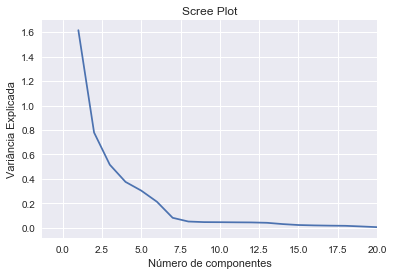

In [9]:
# PCA
# Selecionando N_components

pca = PCA(n_components=X_train.shape[1])
pca.fit(X_train,y_train)

plt.plot([x for x in range(1,X_train.shape[1]+1)], pca.explained_variance_) 
plt.title('Scree Plot')
plt.xlabel('Número de componentes')
plt.ylabel('Variância Explicada')
plt.xlim(xmax=20)
plt.show()

In [10]:
comps = [6,7,8]

results = []

for i in comps:
    r_pca = {}
    pca_test = PCA(n_components=i).fit(X_train, y_train)
    pca_clf = GaussianNB()
    pca_clf.fit(pca_test.transform(X_train), y_train)
    y_pred = pca_clf.predict(pca_test.transform(X_test))
    r_pca['method'] = 'PCA'
    r_pca['n_components'] = i
    r_pca['accuracy'] = accuracy_score(y_test, y_pred)
    r_pca['fbeta'] = fbeta_score(y_test, y_pred, 2)
    results.append(r_pca)
    
    r_kbest = {}
    kbest = SelectKBest(f_classif, k=i).fit(X_train, y_train)
    kbest_clf = GaussianNB()
    kbest_clf.fit(kbest.transform(X_train), y_train)
    y_pred = kbest_clf.predict(kbest.transform(X_test))
    r_kbest['method'] = 'SlectKBest'
    r_kbest['n_components'] = i
    r_kbest['accuracy'] = accuracy_score(y_test, y_pred)
    r_kbest['fbeta'] = fbeta_score(y_test, y_pred, 2)
    results.append(r_kbest)
    
r_basic = {}
basic = GaussianNB()
basic.fit(X_train, y_train)
y_pred = basic.predict(X_test)
r_basic['method'] = 'None'
r_basic['n_components'] = 0
r_basic['accuracy'] = accuracy_score(y_test, y_pred)
r_basic['fbeta'] = fbeta_score(y_test, y_pred, 2)
results.append(r_basic)

df_results = pd.DataFrame(results)
df_results = df_results[['method', 'n_components', 'fbeta', 'accuracy']].copy()
df_results.sort_values(['fbeta'], ascending=False)

,method,n_components,fbeta,accuracy
6,None,0,0.768605,0.520755
5,SlectKBest,8,0.767569,0.515802
1,SlectKBest,6,0.757023,0.453809
3,SlectKBest,7,0.757005,0.453841
4,PCA,8,0.754544,0.590218
2,PCA,7,0.748677,0.585840
0,PCA,6,0.744283,0.588935


#### Conclusão: melhor resultado: PCA(n_components=8)

In [9]:
pca_final = PCA(n_components=8).fit(X_train,y_train)
new_X_train = pca_final.transform(X_train)
new_X_test = pca_final.transform(X_test)

with open('../input/pickles/pca_final.pkl', 'wb') as f:
    pickle.dump(pca_final, f)

## Model Evaluation

1. Modelos a serem testados:
    1. Logistic Regression
    2. Decision Tree
    3. GradientBoosting
    4. Neural Network
2. Método de escolha:
    1. Será usado o modelo básico de cada um deles
    2. Será usado a acurácia e a matriz de confusão para avaliar os métodos.
        1. a acurácia foi escolhida pois as classes não são desbalanceadas e é uma métrica simples de comunicar
        2. o recall será utilizado para critério de desempate, se houver.
            1. Recall nesse cenário: quanto menor o recall mais a chance da fazenda deixar de cobrar daquele contribuinte que pagaria o débito.

In [17]:
model_results = []

In [26]:
#SGD Classifier
start = time()
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(new_X_train, y_train)
end = time()
sgd_y_pred = sgd_clf.predict(new_X_test)

r = {}
r['training_time'] = round(end - start, 3)
r['accuracy'] = accuracy_score(y_test, sgd_y_pred)
r['fbeta'] = fbeta_score(y_test, sgd_y_pred, 2)
r['model'] = 'SGD Classifier'

model_results.append(r)

C:\Users\uaqui\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


In [19]:
# Logistic Regression
start = time()
lreg_clf = LogisticRegression(random_state=42)
lreg_clf.fit(new_X_train, y_train)
end = time()
lreg_y_pred = lreg_clf.predict(new_X_test)

r = {}
r['training_time'] = round(end - start, 3)
r['accuracy'] = accuracy_score(y_test, lreg_y_pred)
r['fbeta'] = fbeta_score(y_test, lreg_y_pred, 2)
r['model'] = 'Logistic Regression'

model_results.append(r)

C:\Users\uaqui\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [20]:
#SGD + Kernel Approximation
start = time()
rbf_sampler = RBFSampler(gamma=1, random_state=42).fit(new_X_train, y_train)
krn_clf = SGDClassifier(random_state=42)
krn_clf.fit(rbf_sampler.transform(new_X_train), y_train)
end = time()
krn_y_pred = krn_clf.predict(rbf_sampler.transform(new_X_test))

r = {}
r['training_time'] = round(end - start, 3)
r['accuracy'] = accuracy_score(y_test, krn_y_pred)
r['fbeta'] = fbeta_score(y_test, krn_y_pred, 2)
r['model'] = 'SGD + Kernel'

model_results.append(r)

C:\Users\uaqui\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


In [21]:
# Random Forest
start = time()
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(new_X_train, y_train)
end = time()
rf_y_pred = rf_clf.predict(new_X_test)

r = {}
r['training_time'] = round(end - start, 3)
r['accuracy'] = accuracy_score(y_test, rf_y_pred)
r['fbeta'] = fbeta_score(y_test, rf_y_pred, 2)
r['model'] = 'Random Forest'

model_results.append(r)

C:\Users\uaqui\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [22]:
#GradientBoosting
start = time()
grad_clf = GradientBoostingClassifier(random_state=42)
grad_clf.fit(new_X_train, y_train)
end = time()
grad_y_pred = grad_clf.predict(new_X_test)

r = {}
r['training_time'] = round(end - start, 3)
r['accuracy'] = accuracy_score(y_test, grad_y_pred)
r['fbeta'] = fbeta_score(y_test, grad_y_pred, 2)
r['model'] = 'Gradient Boosting'

model_results.append(r)

In [23]:
# MLPClassifier
start = time()
mlp_clf = MLPClassifier(random_state=42)
mlp_clf.fit(new_X_train, y_train)
end = time()
mlp_y_pred = mlp_clf.predict(new_X_test)

r = {}
r['training_time'] = round(end - start, 3)
r['accuracy'] = accuracy_score(y_test, mlp_y_pred)
r['fbeta'] = fbeta_score(y_test, mlp_y_pred, 2)
r['model'] = 'MLPClassifier'

model_results.append(r)

In [33]:
model_df = pd.DataFrame(model_results)
model_df = model_df[['model', 'training_time', 'fbeta', 'accuracy']]
model_df = model_df.round(3)
model_df.sort_values(['fbeta'], ascending=False)

,model,training_time,fbeta,accuracy
4,MLPClassifier,266.727,0.669,0.760
1,SGD + Kernel,5.663,0.666,0.741
2,Random Forest,70.505,0.639,0.760
3,Gradient Boosting,288.982,0.630,0.747
5,SGD Classifier,1.515,0.571,0.701
0,Logistic Regression,6.405,0.493,0.697


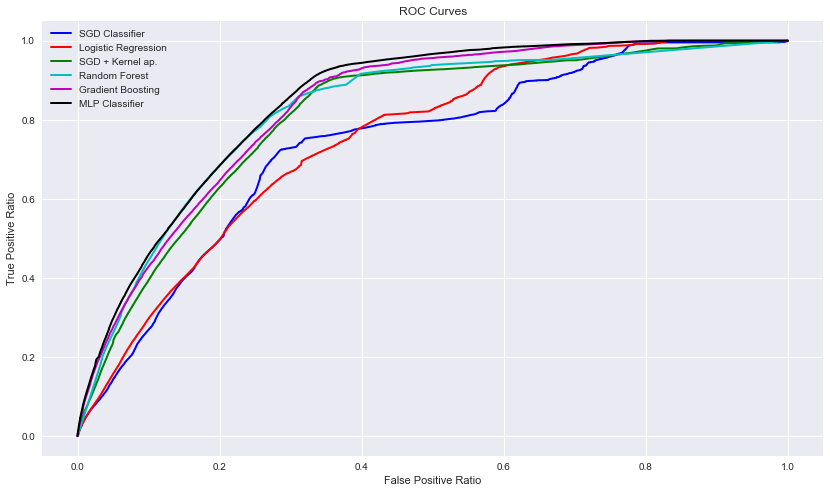

In [34]:
from sklearn.metrics import roc_curve

plt.figure(num=None, figsize=(14, 8))

fpr, tpr, thresholds = roc_curve(y_test,sgd_clf.decision_function(new_X_test),pos_label=1)
plt.plot(fpr, tpr, linewidth=2, color='b', label='SGD Classifier')

fpr, tpr, thresholds = roc_curve(y_test,lreg_clf.decision_function(new_X_test),pos_label=1)
plt.plot(fpr, tpr, linewidth=2, color='r', label='Logistic Regression')

fpr, tpr, thresholds = roc_curve(y_test,krn_clf.decision_function(rbf_sampler.transform(new_X_test)),pos_label=1)
plt.plot(fpr, tpr, linewidth=2, color='g', label='SGD + Kernel ap.')

fpr, tpr, thresholds = roc_curve(y_test,rf_clf.predict_proba(new_X_test)[:,1],pos_label=1)
plt.plot(fpr, tpr, linewidth=2, color='c', label='Random Forest')

fpr, tpr, thresholds = roc_curve(y_test,grad_clf.predict_proba(new_X_test)[:,1],pos_label=1)
plt.plot(fpr, tpr, linewidth=2, color='m', label='Gradient Boosting')

fpr, tpr, thresholds = roc_curve(y_test,mlp_clf.predict_proba(new_X_test)[:,1],pos_label=1)
plt.plot(fpr, tpr, linewidth=2, color='k', label='MLP Classifier')

plt.legend()
plt.xlabel('False Positive Ratio')
plt.ylabel('True Positive Ratio')
plt.title("ROC Curves")
plt.show()


##### Conclusão: 

1. Considerações:
    1. O conjunto de dados é grande, ou seja, o risco de overfitting é maior
    2. Métodos com muita variância tendem mais ao overfitting
    3. Estratégia: usar o gridSearchCV para fazer o Tunning do SGD + Kernel. O melhor modelo, MLPCLassifier, apresentou um tempo de treino muito alto, o que inviabiliza o trabalho.

##  Tunning

In [36]:
from sklearn.pipeline import Pipeline

rbf_sampler = RBFSampler(random_state=42)
clf = SGDClassifier(random_state=42)

pipe = Pipeline([('rbf_sampler', rbf_sampler), ('clf', clf)])

parameters = {'clf__loss':['log', 'modified_huber'], # os únicos que dão probabilidades,
              'clf__penalty':['l1', 'l2', 'none', 'elasticnet'],
              'clf__alpha':[1e-3, 1e-2, 1e-1],
              'clf__class_weight':['balanced'],
              'clf__tol':[1e-4, 1e-3, 1e-2],
              
              'rbf_sampler__gamma':[0.1, 1, 10],
              'rbf_sampler__n_components':[100,150]
             }

strat_fold = StratifiedKFold(n_splits=5)
ftwo_scorer = make_scorer(fbeta_score, beta=2)

grid_search = GridSearchCV(pipe, parameters, scoring = ftwo_scorer,
                           cv = strat_fold, verbose=3, n_jobs=2)
grid_search.fit(new_X_train, y_train)

print('best score:',grid_search.best_score_) 
print('best parameters:',grid_search.best_params_)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  6.1min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed: 18.7min
[Parallel(n_jobs=2)]: Done 284 tasks      | elapsed: 35.3min
[Parallel(n_jobs=2)]: Done 508 tasks      | elapsed: 65.4min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed: 106.0min
[Parallel(n_jobs=2)]: Done 1148 tasks      | elapsed: 154.5min
[Parallel(n_jobs=2)]: Done 1564 tasks      | elapsed: 208.5min
[Parallel(n_jobs=2)]: Done 2044 tasks      | elapsed: 292.0min
[Parallel(n_jobs=2)]: Done 2160 out of 2160 | elapsed: 427.3min finished


best score: 0.7740466165493445
best parameters: {'clf__alpha': 0.001, 'clf__class_weight': 'balanced', 'clf__loss': 'modified_huber', 'clf__penalty': 'none', 'clf__tol': 0.0001, 'rbf_sampler__gamma': 1, 'rbf_sampler__n_components': 150}


In [18]:
# Ajuste Fino
from sklearn.model_selection import cross_val_score

rbf_sampler = RBFSampler(random_state=42, n_components=150, gamma=3)
clf = SGDClassifier(random_state=42, alpha=0.001, loss='modified_huber',
                    penalty='none', class_weight='balanced', tol=1e-4,
                   early_stopping=True)

rbf_sampler.fit(new_X_train, y_train)
clf.fit(rbf_sampler.transform(new_X_train), y_train)

strat_fold = StratifiedKFold(n_splits=5)
ftwo_scorer = make_scorer(fbeta_score, beta=2)

score = cross_val_score(clf, rbf_sampler.transform(new_X_train), y_train,
                cv=strat_fold, scoring=ftwo_scorer)

print('Ajuste fino, fbeta score: {:.3f}'.format(score.mean()))

Ajuste fino, fbeta score: 0.783


### Avaliação e Validação do Modelo

#### Encaixe do modelo final

In [72]:
from sklearn.model_selection import cross_val_score

rbf_sampler = RBFSampler(random_state=42, n_components=150, gamma=3)
clf = SGDClassifier(random_state=42, alpha=0.001, loss='modified_huber',
                    penalty='none', class_weight='balanced', tol=1e-4)

rbf_sampler.fit(new_X_train, y_train)
clf.fit(rbf_sampler.transform(new_X_train), y_train)

SGDClassifier(alpha=0.001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
       max_iter=None, n_iter=None, n_iter_no_change=5, n_jobs=None,
       penalty='none', power_t=0.5, random_state=42, shuffle=True,
       tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False)

In [65]:
# Reformulando treino e test
X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.3, random_state=0)
new_X_train = pca_final.transform(X_train)
new_X_test = pca_final.transform(X_test)

In [66]:
validations = []

#### Estratégia 1: Cross Validation no conjunto de treino

In [67]:
ftwo_scorer = make_scorer(fbeta_score, beta=2)
strat_fold = StratifiedKFold(n_splits=3)

fbeta = cross_val_score(clf, rbf_sampler.transform(new_X_train), y_train, cv=strat_fold, scoring=ftwo_scorer)
acc = cross_val_score(clf, rbf_sampler.transform(new_X_train), y_train, cv=strat_fold, scoring='accuracy')

r = {}
r['Estratégia'] = 1
r['Fbeta'] = fbeta.mean()
r['Accuracy'] = acc.mean()

validations.append(r)

#### Estratégia 2: Teste e Treino

In [68]:
y_pred = clf.predict(rbf_sampler.transform(new_X_test))

acc = accuracy_score(y_test, y_pred)
fbeta = fbeta_score(y_test, y_pred, 2)

r = {}
r['Estratégia'] = 2
r['Fbeta'] = fbeta
r['Accuracy'] = acc

validations.append(r)

#### Estratégia 3: Cross Validation

In [69]:
ftwo_scorer = make_scorer(fbeta_score, beta=2)
strat_fold = StratifiedKFold(n_splits=3)

fbeta = cross_val_score(clf, rbf_sampler.transform(new_X_test), y_test, cv=strat_fold, scoring=ftwo_scorer)
acc = cross_val_score(clf, rbf_sampler.transform(new_X_test), y_test, cv=strat_fold, scoring='accuracy')

r = {}
r['Estratégia'] = 3
r['Fbeta'] = fbeta.mean()
r['Accuracy'] = acc.mean()

validations.append(r)

#### Analisando os resultados

In [70]:
validate_df = pd.DataFrame(validations)
validate_df = validate_df[['Estratégia', 'Fbeta', 'Accuracy']]
validate_df = validate_df.round(3)

validate_df.sort_values(['Estratégia'])

,Estratégia,Fbeta,Accuracy
0,1,0.784,0.736
1,2,0.783,0.736
2,3,0.784,0.735


####  Analisando o modelo de benchmark

In [71]:
bmk = GaussianNB()

X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.2, random_state=42)
bmk.fit(X_train, y_train)

bmk_val = []
X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.3, random_state=0)


# Estratégia 1
ftwo_scorer = make_scorer(fbeta_score, beta=2)
strat_fold = StratifiedKFold(n_splits=3)
fbeta = cross_val_score(bmk, X_train, y_train, cv=strat_fold, scoring=ftwo_scorer)
acc = cross_val_score(bmk, X_train, y_train, cv=strat_fold, scoring='accuracy')
r = {}
r['Estratégia'] = 1
r['Fbeta'] = fbeta.mean()
r['Accuracy'] = acc.mean()
bmk_val.append(r)

# Estratégia 2
y_pred = bmk.predict(X_test)
acc = accuracy_score(y_test, y_pred)
fbeta = fbeta_score(y_test, y_pred, 2)
r = {}
r['Estratégia'] = 2
r['Fbeta'] = fbeta
r['Accuracy'] = acc
bmk_val.append(r)

#Estratégia 3
ftwo_scorer = make_scorer(fbeta_score, beta=2)
strat_fold = StratifiedKFold(n_splits=3)
fbeta = cross_val_score(bmk, X_test, y_test, cv=strat_fold, scoring=ftwo_scorer)
acc = cross_val_score(bmk, X_test, y_test, cv=strat_fold, scoring='accuracy')
r = {}
r['Estratégia'] = 3
r['Fbeta'] = fbeta.mean()
r['Accuracy'] = acc.mean()
bmk_val.append(r)


bmk_df = pd.DataFrame(bmk_val)
bmk_df = bmk_df[['Estratégia', 'Fbeta', 'Accuracy']]
bmk_df = bmk_df.round(3)

bmk_df.sort_values(['Estratégia'])

,Estratégia,Fbeta,Accuracy
0,1,0.767,0.521
1,2,0.767,0.520
2,3,0.767,0.520


In [73]:
with open('../input/pickles/clf.pkl', 'wb') as f:
    pickle.dump(clf, f)
    
with open('../input/pickles/rbf_sampler.pkl', 'wb') as f:
    pickle.dump(rbf_sampler, f)

## Determinando as porcentagens dos débitos não pagos

In [10]:
with open('../input/pickles/df_clean.pkl', 'rb') as f:
    df_clean = pickle.load(f)

with open('../input/pickles/scl_principal.pkl', 'rb') as f:
    scl_principal = pickle.load(f)
    
with open('../input/pickles/scl_qtd_debitos.pkl', 'rb') as f:
    scl_qtd_debitos = pickle.load(f)
    
with open('../input/pickles/clf.pkl', 'rb') as f:
    clf = pickle.load(f)

with open('../input/pickles/rbf_sampler.pkl', 'rb') as f:
    rbf_sampler = pickle.load(f)
    
with open('../input/pickles/pca_final.pkl', 'rb') as f:
    pca_final = pickle.load(f)

In [11]:
df_final = df_clean.copy()

df_final['log_principal'] = scl_principal.transform(df_final.log_principal.values.reshape(-1,1))
df_final['log_debitos_contribuinte'] = scl_qtd_debitos.transform(df_final.log_debitos_contribuinte.values.reshape(-1,1))

#i_cobraveis = [True if x == 'Não Cobrável' else False for x in df_final.target]
target = df_final.target.values
df_final.drop(['COD_TIP_ATLZ_DEB', 'PRINCIPAL', 'COD_DEB', 'dias_ate_pagar',
               'debitos_contribuinte', 'target'], axis=1, inplace=True)

# Dummies
df_final = pd.get_dummies(df_final)
#df_final = df_final[i_cobraveis]

X_final = df_final.copy()

X_final = pca_final.transform(X_final)

In [12]:
proba = clf.predict_proba(rbf_sampler.transform(X_final))

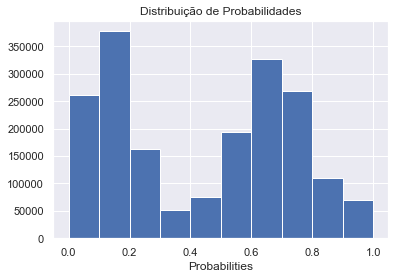

In [8]:
#clf.classes_
plt.hist(proba[:,1])
plt.title('Distribuição de Probabilidades')
plt.xlabel('Probabilities')
plt.show()

In [20]:
df_cob = df_clean.copy()
df_cob['Probabilidades'] = proba[:,1]
df_cob.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1900846 entries, 13 to 2739772
Data columns (total 14 columns):
COD_DEB                     category
COD_SSIS_ORIG               category
COD_TIP_ATLZ_DEB            category
DESC_TIP_CTBU_ORIG          category
DESC_TIP_DEB                category
DESC_TIP_LANC               category
MES                         category
debitos_contribuinte        float64
dias_ate_pagar              float64
target                      category
PRINCIPAL                   float64
log_principal               float64
log_debitos_contribuinte    float64
Probabilidades              float64
dtypes: category(8), float64(6)
memory usage: 221.3 MB


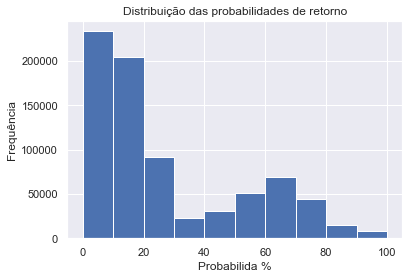

In [21]:
perc_probs = df_cob[df_cob.COD_TIP_ATLZ_DEB.isin(['I', 'A'])].Probabilidades.values * 100
plt.hist(perc_probs)
plt.title('Distribuição das probabilidades de retorno')
plt.xlabel('Probabilida %')
plt.ylabel('Frequência')

plt.show()

In [22]:
sum(perc_probs > 60)

137352

In [23]:
sum(df_cob[(df_cob.COD_TIP_ATLZ_DEB.isin(['I', 'A'])) & (df_cob.Probabilidades > 0.6)].PRINCIPAL.values)

76678006.65003692

In [24]:
with open('../input/pickles/df_cob.pkl', 'wb') as f:
    pickle.dump(df_cob, f)